<a href="https://colab.research.google.com/github/dmbritton1/Beijing-Pollution-Model/blob/main/Beijing_Air_Quality_Forecasting_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Beijing Air Quality Forecasting Model Using Long Short Term Memory**

### Dataset conatins hourly pollution data in Beijing, China from 2010-2014

Imports packages to preprocess data

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

Reads the data

In [ ]:
df = pd.read_csv('/content/FILE/LSTM-Multivariate_pollution.csv')
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


Converts index to timestamp and makes a dataframe of the date column

In [ ]:
df.index = pd.to_datetime(df['date'])
date_frame = df.pop('date')
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


Creates a matrix using the window size to select the previous values and their corresponding label

In [ ]:
def df_to_X_y(df, window_size):
    df_values = df.values.flatten()
    X = []
    y = []
    for i in range(len(df_values) - window_size):
        row = df_values[i:i + window_size].reshape(-1, 1)
        X.append(row)
        label = df_values[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

In [ ]:
X1, y1 = df_to_X_y(df['pollution'], 3)
X1.shape, y1.shape

((43797, 3, 1), (43797,))

Splits the data into train, val, and test

In [ ]:
X_train1, y_train1 = X1[:30000], y1[:30000]
X_val1, y_val1 = X1[30000:35000], y1[30000:35000]
X_test1, y_test1 = X1[35000:], y1[35000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((30000, 3, 1), (30000,), (5000, 3, 1), (5000,), (8797, 3, 1), (8797,))

Imports necessary tensorflow packages and builds the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Lion

model = Sequential()
model.add(InputLayer((3, 1)))
model.add(LSTM(64))
model.add(Dense(16, 'relu'))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18081 (70.63 KB)
Trainable params: 18081 (70.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Defines a checkpoint, loss function, optimizer, and evaluation metric

In [ ]:
checkpoint = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Lion(learning_rate=0.0002), metrics=[RootMeanSquaredError()])

Trains the model on the training data for 10 epochs

In [ ]:
model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[checkpoint])

Epoch 1/10
938/938 [==============================] - 13s 11ms/step - loss: 16844.2227 - root_mean_squared_error: 129.7853 - val_loss: 11811.5244 - val_root_mean_squared_error: 108.6808
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 12272.3145 - root_mean_squared_error: 110.7805 - val_loss: 6413.2720 - val_root_mean_squared_error: 80.0829
Epoch 3/10
938/938 [==============================] - 9s 9ms/step - loss: 6113.7822 - root_mean_squared_error: 78.1907 - val_loss: 2040.9780 - val_root_mean_squared_error: 45.1772
Epoch 4/10
938/938 [==============================] - 10s 11ms/step - loss: 2078.1167 - root_mean_squared_error: 45.5864 - val_loss: 541.7454 - val_root_mean_squared_error: 23.2754
Epoch 5/10
938/938 [==============================] - 9s 10ms/step - loss: 894.5114 - root_mean_squared_error: 29.9084 - val_loss: 462.1041 - val_root_mean_squared_error: 21.4966
Epoch 6/10
938/938 [==============================] - 4s 5ms/step - loss: 823.8379 - root_m

Loads the model that was saved at the checkpoint

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model/')

Runs training data through model and outputs the predictions in a dataframe

In [ ]:
train_predictions = model.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Prediction':train_predictions, 'Actual Value':y_train1})
train_results.index = date_frame[:30000]

train_results

938/938 [==============================] - 3s 3ms/step


,Prediction,Actual Value
date,,
2010-01-02 00:00:00,160.857437,181.0
2010-01-02 01:00:00,189.274139,138.0
2010-01-02 02:00:00,119.445206,109.0
2010-01-02 03:00:00,99.780998,105.0
2010-01-02 04:00:00,101.970993,124.0
...,...,...
2013-06-04 19:00:00,104.099792,101.0
2013-06-04 20:00:00,98.651810,89.0
2013-06-04 21:00:00,86.962791,76.0


Graphs a section of the resulting dataframe

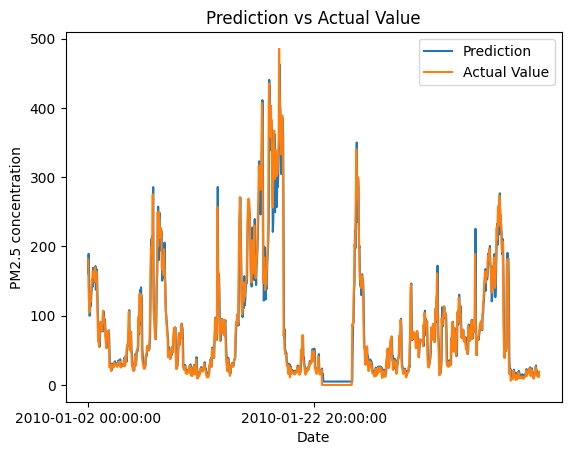

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Prediction'][:1000], label='Prediction')
plt.plot(train_results['Actual Value'][:1000], label='Actual Value')

plt.xticks(train_results.index[:1000:500])

plt.xlabel('Date')
plt.ylabel('PM2.5 concentration')
plt.legend()
plt.title('Prediction vs Actual Value')
plt.show()

Runs valuation data through the model and outputs it to a dataframe

In [ ]:
val_predictions = model.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Prediction':val_predictions, 'Actual Value':y_val1})
val_results.index = date_frame[30000:35000]

val_results

157/157 [==============================] - 0s 3ms/step


,Prediction,Actual Value
date,,
2013-06-05 00:00:00,73.362808,69.0
2013-06-05 01:00:00,68.672470,77.0
2013-06-05 02:00:00,76.587784,78.0
2013-06-05 03:00:00,77.319260,93.0
2013-06-05 04:00:00,93.666016,109.0
...,...,...
2013-12-30 03:00:00,4.885876,0.0
2013-12-30 04:00:00,4.885876,0.0
2013-12-30 05:00:00,4.885876,0.0


Graphs a section of the resulting dataframe

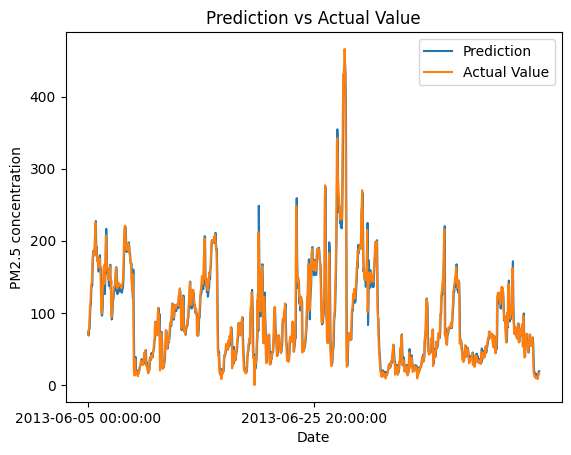

In [ ]:
plt.plot(val_results['Prediction'][:1000], label='Prediction')
plt.plot(val_results['Actual Value'][:1000], label='Actual Value')

plt.xticks(val_results.index[:1000:500])

plt.xlabel('Date')
plt.ylabel('PM2.5 concentration')
plt.legend()
plt.title('Prediction vs Actual Value')
plt.show()

Runs the testing data through the model and outputs it to a dataframe

In [ ]:
test_predictions = model.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Prediction':test_predictions, 'Actual Value':y_test1})
test_results.index = date_frame[35000:43797]

test_results

275/275 [==============================] - 1s 2ms/step


,Prediction,Actual Value
date,,
2013-12-30 08:00:00,4.885876,34.0
2013-12-30 09:00:00,20.195473,25.0
2013-12-30 10:00:00,24.248196,27.0
2013-12-30 11:00:00,28.523876,25.0
2013-12-30 12:00:00,26.183811,25.0
...,...,...
2014-12-31 16:00:00,13.711933,8.0
2014-12-31 17:00:00,11.906636,10.0
2014-12-31 18:00:00,13.443034,10.0


Graphs a section of the resulting dataframe

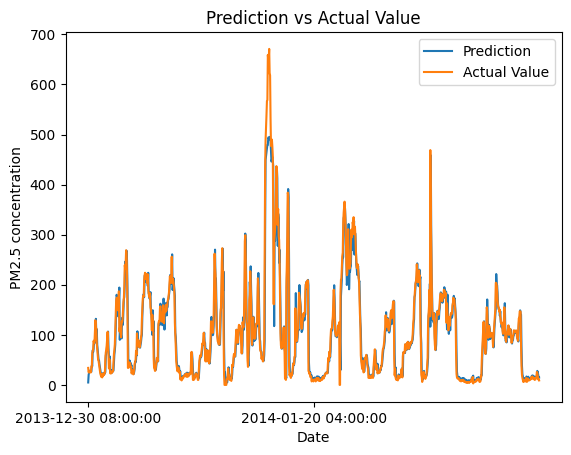

In [ ]:
plt.plot(test_results['Prediction'][:1000], label='Prediction')
plt.plot(test_results['Actual Value'][:1000], label='Actual Value')

plt.xticks(test_results.index[:1000:500])

plt.xlabel('Date')
plt.ylabel('PM2.5 concentration')
plt.legend()
plt.title('Prediction vs Actual Value')
plt.show()